In [19]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize,basinhopping
import io
from PIL import Image


In [20]:
# 指定文件夹路径
folder_path = 'testphotos'
# 获取文件夹下的所有文件和子文件夹
files_and_folders = os.listdir(folder_path)
# 过滤出文件
photoname = [file for file in files_and_folders if os.path.isfile(os.path.join(folder_path, file))]
photopath = [os.path.join(folder_path, file) for file in files_and_folders if os.path.isfile(os.path.join(folder_path, file))]
print(photopath)

['testphotos\\1.png', 'testphotos\\2.png', 'testphotos\\img copy 2.png', 'testphotos\\img copy.png', 'testphotos\\img.png']


In [21]:
'''d0默认值为10:
这是一个参数,用于定义高通滤波器的截止频率。d0 控制了滤波器对低频成分的衰减程度,即距离原点（0频率）多远的频率成分开始被衰减。

rl默认值为0.5:
这是滤波器在低频区域的增益。rl 控制了滤波器对低频成分的保留程度。

rh默认值为2.0:
这是滤波器在高频区域的增益。rh 控制了滤波器对高频成分的增强程度。

c默认值为4:锐化系数
这是一个参数,用于控制滤波器的陡峭程度。c 的值越大，滤波器的过渡带就越窄，即从低频到高频的过渡就越快。

h默认值为2.0:
这是输出图像的最大值。在同态滤波过程中,可能会产生超出常规图像值范围（0-255）的结果，h 用于将结果缩放到这个最大值。

l默认值为0.5:

这是输出图像的最小值。与 h 类似,l 用于确保输出图像的值不会低于这个最小值。'''
def homomorphic_filter(src, d0=10, rl=1, rh=2, c=4, h=2.0, l=0.5):
    gray = src.copy()
    gray = np.log(1e-5 + gray)  # 取对数
    rows, cols = gray.shape
    gray_fft = np.fft.fft2(gray)  # FFT傅里叶变换
    gray_fftshift = np.fft.fftshift(gray_fft)  # FFT中心化
    M, N = np.meshgrid(np.arange(-cols // 2, cols // 2), np.arange(-rows // 2, rows // 2))
    D = np.sqrt(M ** 2 + N ** 2)  # 计算距离
    Z = (rh - rl) * (1 - np.exp(-c * (D ** 2 / d0 ** 2))) + rl  # H(u,v)传输函数
    dst_fftshift = Z * gray_fftshift
    dst_fftshift = (h - l) * dst_fftshift + l
    dst_ifftshift = np.fft.ifftshift(dst_fftshift)
    dst_ifft = np.fft.ifft2(dst_ifftshift)  # IFFT逆傅里叶变换
    dst = np.real(dst_ifft)  # IFFT取实部
    dst = np.exp(dst) - 1  # 还原
    dst = np.uint8(np.clip(dst, 0, 255))
    return dst

In [22]:
i=0
print(photopath[i])
# 读取图片
image_color = cv2.imread(photopath[i])
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)

testphotos\1.png


4556.456453651686


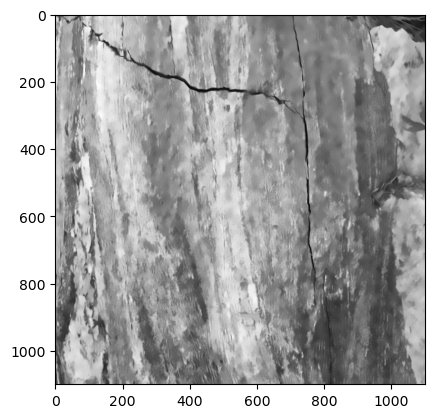

In [23]:
# h 是滤波系数，用于控制去噪强度，值越大去噪效果越强，但可能会导致图像模糊
# templateWindowSize 是用于计算权重的窗口大小，通常为3, 5, 7等奇数
# searchWindowSize 是搜索窗口的大小，通常比templateWindowSize大，也是奇数
laplacian = cv2.Laplacian(image_gray, cv2.CV_64F)
variance = np.var(laplacian, axis=None)
print(variance)
dst = cv2.fastNlMeansDenoising(image_gray, h=30, templateWindowSize=7, searchWindowSize=21)
#plt.imshow(image_gray, cmap='gray')
plt.imshow(dst, cmap='gray')

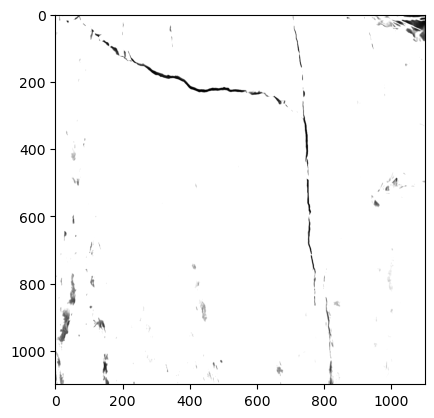

In [24]:
image_homomorphic_filter = homomorphic_filter(dst,d0=10, rl=1, rh=2.5, c=4, h=2, l=0.5)
# 显示结果
plt.imshow(image_homomorphic_filter, cmap='gray')

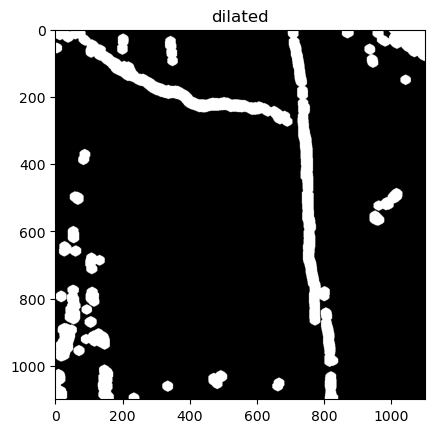

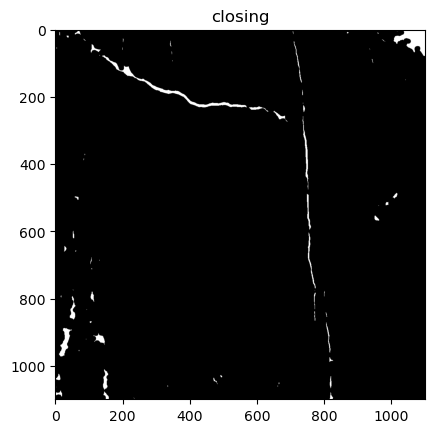

In [25]:
# 闭运算
# 二值化处理，根据需要调整阈值
_, binary_image = cv2.threshold(image_homomorphic_filter * 255, 127, 255, cv2.THRESH_BINARY)

# 定义结构元素，这里使用一个3x3的矩形结构元素
# 创建一个5x5的矩形结构元素
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

# 创建一个5x5的椭圆形结构元素
ellipse_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

# 创建一个5x5的十字形结构元素
cross_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (7, 7))


# 执行膨胀操作
dilated_image = cv2.dilate(binary_image, ellipse_kernel, iterations=5)

plt.title("dilated")
plt.imshow(dilated_image, cmap='gray')
plt.show()


# 定义结构元素，这里使用一个5x5的矩形结构元素

# 创建一个5x5的矩形结构元素
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
# 创建一个5x5的椭圆形结构元素
ellipse_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
# 创建一个5x5的十字形结构元素
cross_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (15, 15))

kernel = np.ones((5, 5), np.uint8)

# 进行闭运算
closing = cv2.morphologyEx(binary_image * 255, cv2.MORPH_CLOSE, ellipse_kernel)
plt.title("closing")
plt.imshow(closing, cmap='gray')
plt.show()

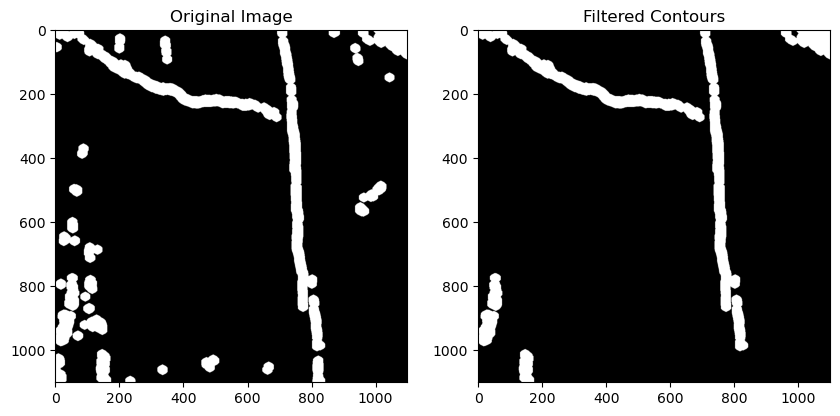

In [26]:
# 检测轮廓
contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 计算自适应面积阈值（例如取轮廓面积的平均值）
areas = [cv2.contourArea(cnt) for cnt in contours]
mean_area = np.mean(areas)

# 设定阈值比例（可以根据需求调整）
area_threshold = 1 * mean_area

# 创建一个空白图像用于绘制符合面积阈值的轮廓
image = np.array(dilated_image)
output = np.zeros(image.shape[:2], dtype='uint8')  # 仅取宽高两维

# 计算轮廓的外接矩形长宽比
def aspect_ratio(contour):
    x, y, w, h = cv2.boundingRect(contour)
    return float(w) / h if h > 0 else 0


# 筛选并绘制符合条件的轮廓
for cnt in contours:
    area = cv2.contourArea(cnt)
    ratio = aspect_ratio(cnt)
    if area >= area_threshold:  # 保留面积大于阈值的轮廓
        cv2.drawContours(output, [cnt], -1, (255), thickness=cv2.FILLED)

areathreshold_img = output
# 显示结果
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(dilated_image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Filtered Contours")
plt.imshow(areathreshold_img, cmap='gray')


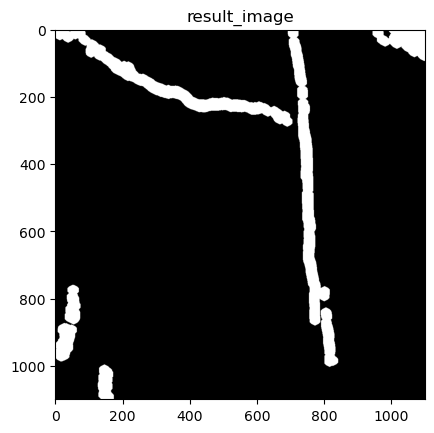

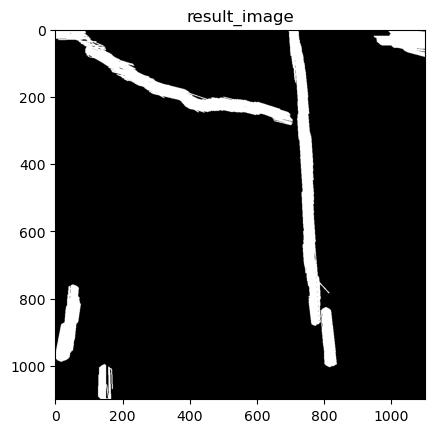

In [27]:
import math

# 计算两条线段之间的夹角（角度制）
def angle_between_segments(segment1, segment2):
    x1, y1, x2, y2 = segment1
    x3, y3, x4, y4 = segment2
    v1 = (x2 - x1, y2 - y1)
    v2 = (x4 - x3, y4 - y3)
    dot_product = v1[0] * v2[0] + v1[1] * v2[1]
    magnitude1 = math.sqrt(v1[0] ** 2 + v1[1] ** 2)
    magnitude2 = math.sqrt(v2[0] ** 2 + v2[1] ** 2)
    cos_angle = dot_product / (magnitude1 * magnitude2)
    return math.degrees(math.acos(cos_angle))


# 计算两点之间的距离
def distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)


# 线段连接函数
def link_segments(segments, distance_threshold=5, angle_threshold=20):
    """
    segments: 线段列表，每个线段用起点和终点坐标表示，例如[(x1,y1,x2,y2), (x3,y3,x4,y4),...]
    distance_threshold: 距离阈值，小于此距离的端点认为可连接
    angle_threshold: 角度阈值，小于此角度的线段认为方向相近可连接
    """
    linked_segments = []
    num_segments = len(segments)
    processed = [False] * num_segments
    for i in range(num_segments):
        if processed[i]:
            continue
        current_segment = segments[i]
        merged_segment = list(current_segment)
        for j in range(i + 1, num_segments):
            if processed[j]:
                continue
            other_segment = segments[j]
            # 检查端点距离
            dist1 = distance((current_segment[2], current_segment[3]), (other_segment[0], other_segment[1]))
            dist2 = distance((current_segment[0], current_segment[1]), (other_segment[2], other_segment[3]))
            if dist1 < distance_threshold or dist2 < distance_threshold:
                # 检查角度
                angle1 = angle_between_segments(current_segment, other_segment)
                angle2 = angle_between_segments((current_segment[2], current_segment[3], current_segment[0], current_segment[1]),
                                               other_segment)
                if angle1 < angle_threshold or angle2 < angle_threshold:
                    # 合并线段
                    if dist1 < distance_threshold:
                        merged_segment[2] = other_segment[2]
                        merged_segment[3] = other_segment[3]
                    else:
                        merged_segment[0] = other_segment[0]
                        merged_segment[1] = other_segment[1]
                    processed[j] = True
        linked_segments.append(tuple(merged_segment))
    return linked_segments


# 使用霍夫变换提取线段
lines = cv2.HoughLinesP(areathreshold_img, 1, np.pi / 180, 50, minLineLength=50, maxLineGap=10)
total_length = 0
num_lines = 0
for line in lines:
    x1, y1, x2, y2 = line[0]
    length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    total_length += length
    num_lines += 1
average_length = total_length / num_lines if num_lines > 0 else 0
# 使用平均线段长度作为 minLineLength 参数再次检测线段
lines_with_avg_length = cv2.HoughLinesP(areathreshold_img, 1, np.pi / 180, 50, minLineLength=int(average_length), maxLineGap=10)

extracted_segments = []
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        extracted_segments.append((x1, y1, x2, y2))

# 对提取的线段进行连接
linked_segments = link_segments(extracted_segments)

# 可以将连接后的线段绘制回图像查看效果（创建一个空白图像用于绘制）
result_image = np.zeros_like(areathreshold_img)
for segment in linked_segments:
    x1, y1, x2, y2 = segment
    cv2.line(result_image, (x1, y1), (x2, y2), 255, 2)


plt.title("result_image")
plt.imshow(areathreshold_img, cmap='gray')
plt.show()
plt.title("result_image")
plt.imshow(result_image, cmap='gray')
plt.show()

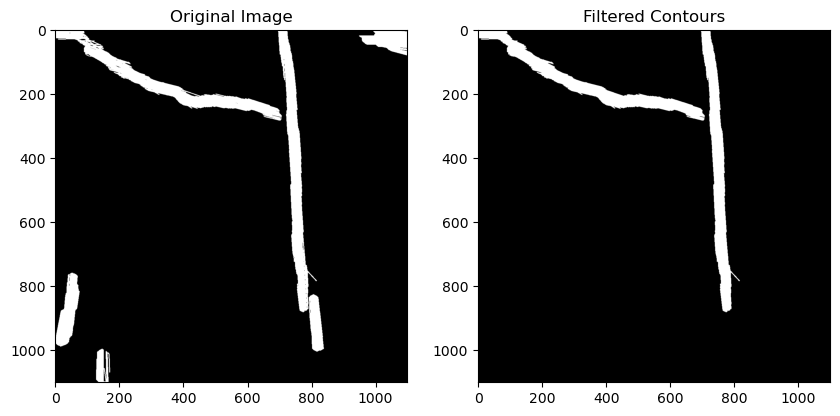

In [28]:
# 应用二值化处理
_, binary = cv2.threshold(result_image.astype(np.uint8), 127, 255, cv2.THRESH_BINARY)
# 检测轮廓
contours, _ = cv2.findContours(result_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 计算自适应面积阈值（例如取轮廓面积的平均值）
areas = [cv2.contourArea(cnt) for cnt in contours]
mean_area = np.mean(areas)

# 设定阈值比例（可以根据需求调整）
area_threshold = 1 * mean_area

# 创建一个空白图像用于绘制符合面积阈值的轮廓
output = np.zeros(image.shape[:2], dtype='uint8')  # 仅取宽高两维

# 计算轮廓的外接矩形长宽比
def aspect_ratio(contour):
    x, y, w, h = cv2.boundingRect(contour)
    return float(w) / h if h > 0 else 0


# 筛选并绘制符合条件的轮廓
for cnt in contours:
    area = cv2.contourArea(cnt)
    ratio = aspect_ratio(cnt)
    if area >= area_threshold and (ratio>2 or ratio<0.3):  # 保留面积大于阈值的轮廓
        cv2.drawContours(output, [cnt], -1, (255), thickness=cv2.FILLED)

areathreshold_img = output

# 显示结果
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(result_image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Filtered Contours")
plt.imshow(areathreshold_img, cmap='gray')


In [29]:
def zhang_suen_thinning1(image):
    # 确保图像为二值化图像
    binary_image = (image > 0).astype(np.uint8)

    def neighbours(x, y):
        """返回给定像素的 8 个邻居像素的值"""
        return [binary_image[x-1, y], binary_image[x-1, y+1], binary_image[x, y+1], binary_image[x+1, y+1],
                binary_image[x+1, y], binary_image[x+1, y-1], binary_image[x, y-1], binary_image[x-1, y-1]]

    def transitions(neighbours):
        """计算从 0 到 1 的转换次数"""
        n = neighbours + neighbours[0:1]  # 环绕一下
        return sum((n1 == 0 and n2 == 1) for n1, n2 in zip(n[:-1], n[1:]))

    def step1():
        """第一步移除点集"""
        to_remove = []
        for i in range(1, binary_image.shape[0] - 1):
            for j in range(1, binary_image.shape[1] - 1):
                P = neighbours(i, j)
                if (binary_image[i, j] == 1 and
                    2 <= sum(P) <= 6 and
                    transitions(P) == 1 and
                    P[0] * P[2] * P[4] == 0 and
                    P[2] * P[4] * P[6] == 0):
                    to_remove.append((i, j))
        for i, j in to_remove:
            binary_image[i, j] = 0

    def step2():
        """第二步移除点集"""
        to_remove = []
        for i in range(1, binary_image.shape[0] - 1):
            for j in range(1, binary_image.shape[1] - 1):
                P = neighbours(i, j)
                if (binary_image[i, j] == 1 and
                    2 <= sum(P) <= 6 and
                    transitions(P) == 1 and
                    P[0] * P[2] * P[6] == 0 and
                    P[0] * P[4] * P[6] == 0):
                    to_remove.append((i, j))
        for i, j in to_remove:
            binary_image[i, j] = 0

    # 执行迭代细化步骤，直到没有像素再被移除
    prev_image = np.zeros(binary_image.shape, np.uint8)
    while True:
        step1()
        step2()
        if np.array_equal(prev_image, binary_image):
            break
        prev_image = binary_image.copy()

    return binary_image


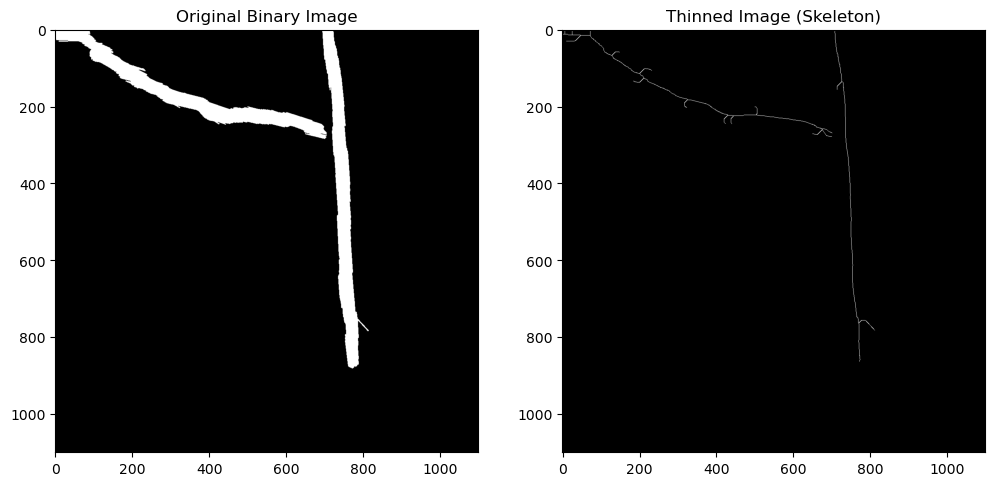

In [30]:
#thinning_img = zhang_suen_thinning(vessleness_img)
thinning_img1 = zhang_suen_thinning1(areathreshold_img)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Binary Image")
plt.imshow(areathreshold_img, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Thinned Image (Skeleton)")
plt.imshow(thinning_img1, cmap='gray')
plt.show()

Text(0.5, 1.0, 'Original Image')

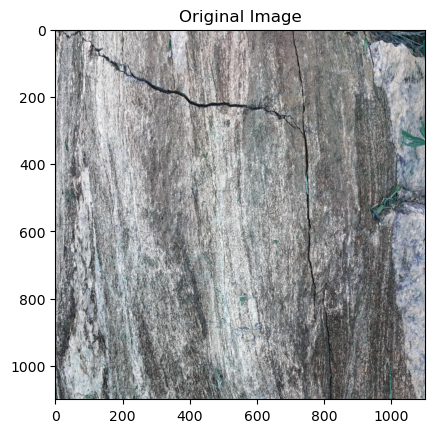

In [31]:
plt.imshow(image_color, cmap='gray')
plt.title('Original Image')